In [7]:
import basis_set_exchange as bse
import scipy as sp
import matplotlib.pyplot as plt
from pyscf import gto,scf
from FcMole import FcM
import copy
import numpy as np
from scipy.interpolate import interp1d

https://pubs.acs.org/doi/abs/10.1021/ed078p391

## Mixing requirement
1) For integer charge return exact basis of the element <br>
2) Should be continuos <br>
3) should have continuos arbitrary order derivatives <br>
or eventually we can define a set for each reference, a parabola passing through reference and two targets.

# Contracted Gaussians

In [8]:
gto.basis.load('sto-3g', 'C'),\
gto.basis.load('sto-3g', 'N')

([[0,
   [71.616837, 0.15432897],
   [13.045096, 0.53532814],
   [3.5305122, 0.44463454]],
  [0,
   [2.9412494, -0.09996723],
   [0.6834831, 0.39951283],
   [0.2222899, 0.70011547]],
  [1,
   [2.9412494, 0.15591627],
   [0.6834831, 0.60768372],
   [0.2222899, 0.39195739]]],
 [[0,
   [99.106169, 0.15432897],
   [18.052312, 0.53532814],
   [4.8856602, 0.44463454]],
  [0,
   [3.7804559, -0.09996723],
   [0.8784966, 0.39951283],
   [0.2857144, 0.70011547]],
  [1,
   [3.7804559, 0.15591627],
   [0.8784966, 0.60768372],
   [0.2857144, 0.39195739]]])

In [9]:
# the coefficients are equal, hope for some result, misleading??

In [10]:
m1=gto.M(atom="N 0 0 0; N 0 0 2.01",unit="Bohrs",basis={"N":"sto-3g"})
m2=gto.M(atom="N1 0 0 0; N2 0 0 2.01",unit="Bohrs",basis={"N1":gto.basis.load('sto-3g', 'C'),\
                                                       "N2":gto.basis.load('sto-3g', 'O')})
mf1=scf.RHF(m1)
mf1.scf()
mf2=scf.RHF(m2)
mf2.scf()

converged SCF energy = -107.481313549373
converged SCF energy = -105.429879166583


-105.42987916658304

In [11]:
b_sto=gto.basis.load('sto-3g', 'B')
c_sto=gto.basis.load('sto-3g', 'C')
n_sto=gto.basis.load('sto-3g', 'N')
o_sto=gto.basis.load('sto-3g', 'O')
f_sto=gto.basis.load('sto-3g', 'F')

In [12]:
for i in n_sto:
    for j in i[1:]:
        print(j[0])

99.106169
18.052312
4.8856602
3.7804559
0.8784966
0.2857144
3.7804559
0.8784966
0.2857144


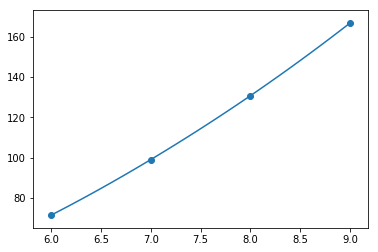

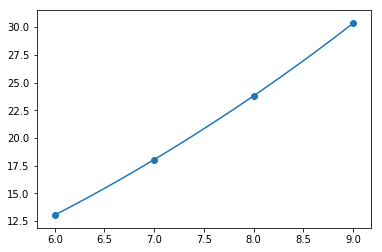

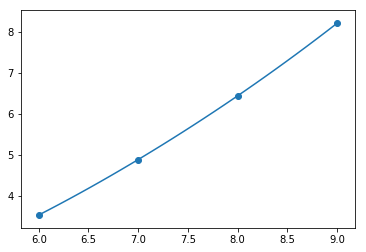

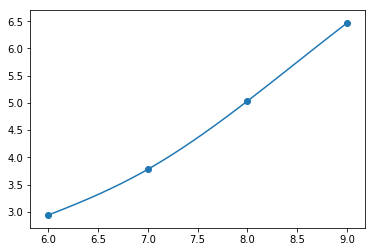

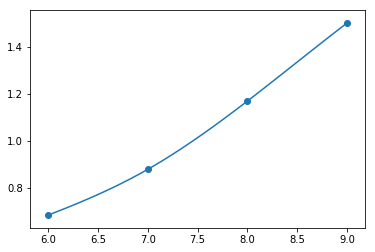

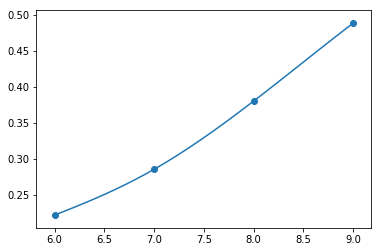

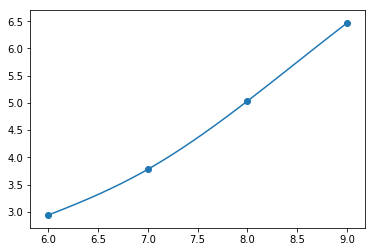

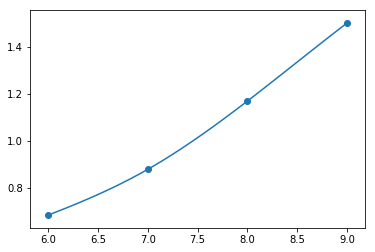

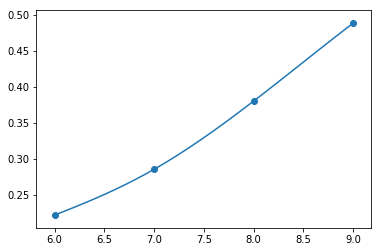

In [17]:
#interpolated coefficients
lsx=np.linspace(6,9,30)
ics_sto=[]
for i in range(len(n_sto)):
    icp=[]
    for j in range(1,len(n_sto[i])):
        ic=interp1d(np.asarray([5,6,7,8,9]),np.asarray([b_sto[i][j][0],c_sto[i][j][0],\
                                       n_sto[i][j][0],o_sto[i][j][0],f_sto[i][j][0]]),kind="cubic")
        icp.append(ic)
        plt.plot(lsx,ic(lsx))
        plt.scatter(np.asarray([6,7,8,9]),np.asarray([c_sto[i][j][0],n_sto[i][j][0],o_sto[i][j][0],f_sto[i][j][0]]))
        plt.show()
    ics_sto.append(icp)

In [23]:
def sto(z):
    r_sto=copy.deepcopy(n_sto)
    for i in range(len(r_sto)):
        for j in range(1,len(r_sto[i])):
            r_sto[i][j][0]=float(ics_sto[i][j-1](z))
    return r_sto

In [24]:
def E(l):
    mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.14",unit="Bohrs",basis={"N1":sto(7-l),"N2":sto(7+l)},verbose=1)
    mf_l=scf.RHF(mol_l)
    e=mf_l.scf(dm0=dm0_nn)
    return e

In [25]:
def E_old(l):
    mol_l=FcM(fcs=[-l,l],atom="N 0 0 0; N 0 0 2.14",unit="Bohrs",basis="sto-3g",verbose=1)
    mf_l=scf.RHF(mol_l)
    e=mf_l.scf(dm0=dm0_nn)
    return e

In [26]:
mf_NN=scf.RHF(gto.M(atom="N 0 0 0; N 0 0 2.14",unit="Bohrs",basis="sto-3g"))
e_0=mf_NN.scf()
dm0_nn=mf_NN.make_rdm1()

converged SCF energy = -107.500647520058


In [27]:
e_T=scf.RHF(gto.M(atom="C 0 0 0; O 0 0 2.14",unit="Bohrs")).scf()

converged SCF energy = -111.224958315392


In [28]:
e_T_R=E_old(1)

In [29]:
E(0)

-107.50064752005761

In [30]:
E(1),E(-1)

(-111.22495831539169, -111.2249583153916)

In [31]:
#finite difference coefficients
fd1=np.asarray([1/12,-2/3 ,0,2/3,-1/12])
fd2=np.asarray([-1/12,4/3,-5/2,4/3,-1/12])
fd3=np.asarray([-1/2,1,0,-1,1/2])
fd4=np.asarray([1,-4,6,-4,1])
fds=[fd1,fd2,fd3,fd4]


In [98]:
dl=.01
Es=np.asarray([E(-2*dl),E(-dl),e_0,E(dl),E(2*dl)])
Es_old=np.asarray([E_old(-2*dl),E_old(-dl),e_0,E_old(dl),E_old(2*dl)])
apdft=[e_0]
inc=[]
for i in range(4):
    inc.append(fds[i].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+fds[i].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1) )
apdft,e_T

([-107.50064752005761,
  -107.50064752005352,
  -111.23571152438673,
  -111.23571153386064,
  -111.22436185710666],
 -111.22495831539155)

In [100]:
dl=.05
Es=np.asarray([E(-2*dl),E(-dl),e_0,E(dl),E(2*dl)])
Es_old=np.asarray([E_old(-2*dl),E_old(-dl),e_0,E_old(dl),E_old(2*dl)])
apdft=[e_0]
inc=[]
for i in range(4):
    inc.append(fds[i].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+fds[i].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1) )
apdft,e_T

([-107.50064752005761,
  -107.50064752005846,
  -111.23571150766372,
  -111.23571150755004,
  -111.22437336726266],
 -111.22495831539155)

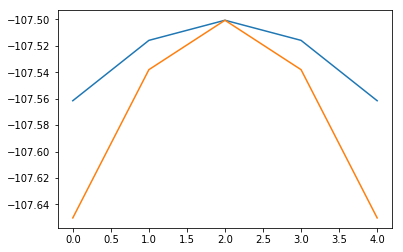

In [34]:
plt.plot(Es_old)
plt.plot(Es)

In [35]:
apdft_old=[e_0]
inc_old=[]
for i in range(4):
    inc_old.append(fds[i].dot(np.asarray(Es_old))/dl**(i+1)/np.math.factorial(i+1))
    apdft_old.append(apdft_old[i]+fds[i].dot(np.asarray(Es_old))/dl**(i+1)/np.math.factorial(i+1) )

In [36]:
apdft_old,e_T_R

([-107.50064752005761,
  -107.50064752005872,
  -109.02343143791852,
  -109.02343143788299,
  -109.00493865913171],
 -109.00556851340599)

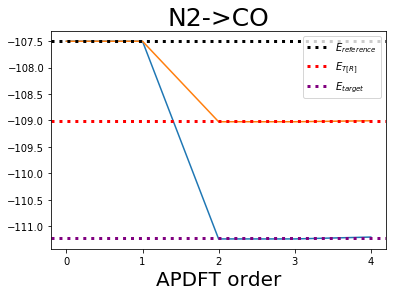

In [37]:
plt.plot([0,1,2,3,4],apdft)
plt.plot([0,1,2,3,4],apdft_old)
plt.title("N2->CO",size=25)
plt.xticks([0,1,2,3,4])
plt.xlabel("APDFT order",size=20)
plt.axhline(e_0,color="black",ls=":",lw=3,label="$E_{reference}$")
plt.axhline(e_T_R,color="red",ls=":",lw=3,label="$E_{T[R]}$")
plt.axhline(e_T,color="purple",ls=":",lw=3,label="$E_{target}$")
plt.legend()
plt.savefig("sto-3G.png")

# Inverse CO->NN

In [101]:
def E_inv(l):
    mol_l=FcM(fcs=[l,-l],atom="C 0 0 0; O 0 0 2.14",unit="Bohrs",basis={"C":sto(6+l),"O":sto(8-l)},verbose=1)
    mf_l=scf.RHF(mol_l)
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return e

In [103]:
dl=.05
Es_inv=np.asarray([E_inv(-2*dl),E_inv(-dl),e_T,E_inv(dl),E_inv(2*dl)])
apdft_inv=[e_T]
inc=[]
for i in range(4):
    inc.append(fds[i].dot(np.asarray(Es_inv))/dl**(i+1)/np.math.factorial(i+1))
    apdft_inv.append(apdft_inv[i]+fds[i].dot(np.asarray(Es_inv))/dl**(i+1)/np.math.factorial(i+1))
e_T,apdft_inv,e_0

(-111.22495831539155,
 [-111.22495831539155,
  -103.79680666045438,
  -107.47175116689668,
  -107.50771956537972,
  -107.50183993366488],
 -107.50064752005761)

In [64]:
mol_l=FcM(fcs=[.02,-.02],atom="C 0 0 0; O 0 0 2.14",unit="Bohrs",basis="sto-3g",verbose=1)
mf_l=scf.RHF(mol_l)
mf_l.scf(dm0=mf_l.init_guess_by_1e())

-111.07920154999778

In [66]:
e_T+50*(-111.07920154999778-e_T)

-103.93712004570304

# Parabola through the neighbouring atoms
(6,c_sto),(7,n_sto),(8,o_sto)
az^2+b^z+c=sto
az^2+b^z+c=sto
az^2+b^z+c=sto

In [84]:
zs=np.array([6,7,8])
zm=np.vstack([zs**2,zs,zs**0]).T
zm,np.array([c_sto[1][1][0],n_sto[1][1][0],o_sto[1][1][0]])

(array([[36,  6,  1],
        [49,  7,  1],
        [64,  8,  1]]), array([2.9412494, 3.7804559, 5.0331513]))

In [87]:
coefs_abc=np.linalg.solve(zm,np.array([c_sto[1][1][0],n_sto[1][1][0],o_sto[1][1][0]]))

In [88]:
zm@coefs_abc

array([2.9412494, 3.7804559, 5.0331513])

In [89]:
def sto(z):
    r_sto=copy.deepcopy(n_sto)
    for i in range(len(r_sto)):
        for j in range(1,len(r_sto[i])):
            coefs_abc=np.linalg.solve(zm,np.array([c_sto[i][j][0],n_sto[i][j][0],o_sto[i][j][0]]))
            r_sto[i][j][0]=coefs_abc.dot(np.array([z**2,z,1]))
    return r_sto

In [90]:
n_sto,sto(7)

([[0,
   [99.106169, 0.15432897],
   [18.052312, 0.53532814],
   [4.8856602, 0.44463454]],
  [0,
   [3.7804559, -0.09996723],
   [0.8784966, 0.39951283],
   [0.2857144, 0.70011547]],
  [1,
   [3.7804559, 0.15591627],
   [0.8784966, 0.60768372],
   [0.2857144, 0.39195739]]],
 [[0,
   [99.10616900000001, 0.15432897],
   [18.052312, 0.53532814],
   [4.885660200000001, 0.44463454]],
  [0,
   [3.7804559000000006, -0.09996723],
   [0.8784965999999996, 0.39951283],
   [0.28571440000000004, 0.70011547]],
  [1,
   [3.7804559000000006, 0.15591627],
   [0.8784965999999996, 0.60768372],
   [0.28571440000000004, 0.39195739]]])

In [92]:
dl=.01
Es=np.asarray([E(-2*dl),E(-dl),e_0,E(dl),E(2*dl)])
Es_old=np.asarray([E_old(-2*dl),E_old(-dl),e_0,E_old(dl),E_old(2*dl)])
apdft=[e_0]
inc=[]
for i in range(4):
    inc.append(fds[i].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+fds[i].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1) )
apdft,e_T

([-107.50064752005761,
  -107.50064752005352,
  -111.2357115242091,
  -111.23571152894604,
  -111.22436291800616],
 -111.22495831539155)